In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv('datasets/processed_dataset.csv')

### Data splitting

In [3]:
random_seed = 47
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['PumpFailed']), 
                                                df['PumpFailed'], test_size=0.3, random_state=random_seed)

In [4]:
print(f'Train df size, X: {x_train.shape}, Y: {y_train.shape}')
print(f'Test df size, X: {x_test.shape}, Y: {y_test.shape}')

Train df size, X: (18830, 388), Y: (18830,)
Test df size, X: (8070, 388), Y: (8070,)


Balance of classes:
0    16769
1     2061
Name: PumpFailed, dtype: int64


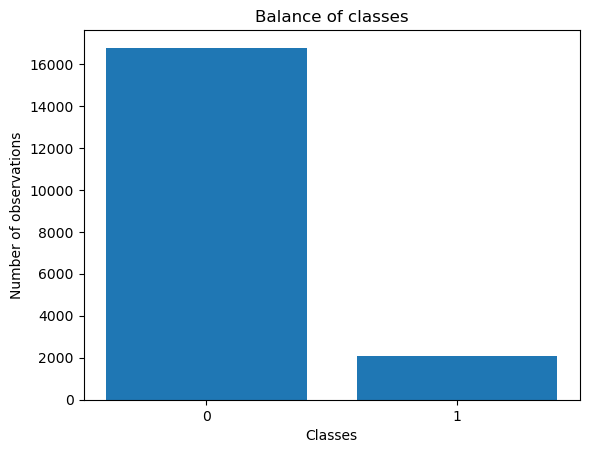

In [5]:
class_counts = y_train.value_counts()
print('Balance of classes:')
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Number of observations')
plt.title('Balance of classes')
plt.xticks([0, 1])
plt.show()

I'll try to balance the minority class using SMOTE.

### SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) is one of the most common methods to remove unbalanced data. This method generates synthetic samples in a minority class.

* SMOTE cannot be used if there are nan values in the dataset, so I replaced them with -9999.
* I also replaced nan values with -9999 for the test set, to see how XGBoost behaves with them.

In [6]:
x_train = x_train.fillna(-9999)
x_test = x_test.fillna(-9999)

In [7]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)

Balance of classes:
0    16769
1    16769
Name: PumpFailed, dtype: int64


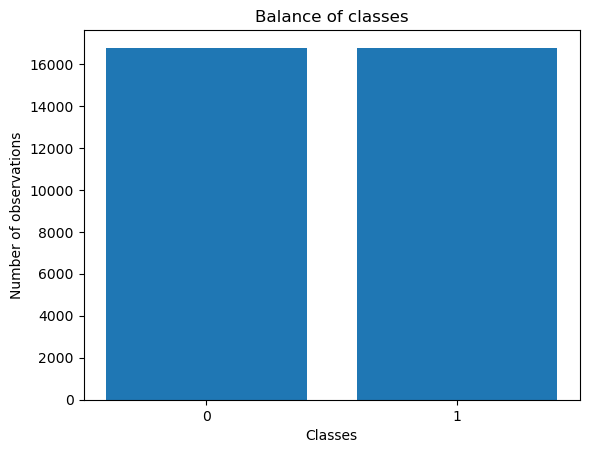

In [8]:
class_counts = y_train_resampled.value_counts()
print('Balance of classes:')
print(class_counts)

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Number of observations')
plt.title('Balance of classes')
plt.xticks([0, 1])
plt.show()

### Modeling using weights

Set class weights to combat unbalanced data. The `scale_pos_weight` parameter in XGBoost allows to set the weight of a rare class compared to a frequent class.

In [9]:
start = time.time()

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        learning_rate=0.01, 
                        max_depth=10, 
                        subsample=0.5, 
                        colsample_bytree=0.7, 
                        n_estimators=200, 
                        reg_lambda=1.1, 
                        min_child_weight=1,
                        scale_pos_weight = ratio)

xgb_clf.fit(x_train, y_train)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

All done. This operation took 0.2 minutes.


#### Metrics

In [10]:
y_pred_train = xgb_clf.predict(x_train)
print('Classification report for training set:')
print(classification_report(y_train, y_pred_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94     16769
           1       0.52      1.00      0.68      2061

    accuracy                           0.90     18830
   macro avg       0.76      0.94      0.81     18830
weighted avg       0.95      0.90      0.91     18830



In [11]:
y_pred_test = xgb_clf.predict(x_test)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      7189
           1       0.50      0.99      0.66       881

    accuracy                           0.89      8070
   macro avg       0.75      0.93      0.80      8070
weighted avg       0.94      0.89      0.91      8070



### TEST with resampled sets

In [12]:
start = time.time()

ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        learning_rate=0.01, 
                        max_depth=10, 
                        subsample=0.5, 
                        colsample_bytree=0.7, 
                        n_estimators=200, 
                        reg_lambda=1.1, 
                        min_child_weight=1,
                        scale_pos_weight = ratio)

xgb_clf.fit(x_train_resampled, y_train_resampled)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

All done. This operation took 0.5 minutes.


In [13]:
y_pred_train_res = xgb_clf.predict(x_train_resampled)
print('Classification report for training set:')
print(classification_report(y_train_resampled, y_pred_train_res))

Classification report for training set:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     16769
           1       0.89      1.00      0.94     16769

    accuracy                           0.94     33538
   macro avg       0.94      0.94      0.94     33538
weighted avg       0.94      0.94      0.94     33538



In [14]:
y_pred_test = xgb_clf.predict(x_test)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      7189
           1       0.48      1.00      0.65       881

    accuracy                           0.88      8070
   macro avg       0.74      0.93      0.79      8070
weighted avg       0.94      0.88      0.90      8070



#### `Precision` shows how much we can trust the model's predictions when it says that an object belongs to a certain class. 
#### `Recall` shows how well the model can identify all objects of a particular class. 

* Precision for class 0 is 1.00, which means that every time the model predicts class 0, it is always right. However, the precision for class 1 is 0.48, meaning that of all the cases that the model predicted as class 1, only 48% of them were actually class 1.

* Recall for class 0 is 0.87, meaning that the model found 87% of all actual positive class 0 cases. However, recall for class 1 is 1.00, meaning that the model found all real positive cases of class 1.

### Modeling without using weights

In [15]:
start = time.time()

xgb_clf = XGBClassifier(objective='binary:logistic', 
                        learning_rate=0.01, 
                        max_depth=10, 
                        subsample=0.5, 
                        colsample_bytree=0.7, 
                        n_estimators=200, 
                        reg_lambda=1.1, 
                        min_child_weight=1)

xgb_clf.fit(x_train, y_train)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

All done. This operation took 0.2 minutes.


In [16]:
y_pred_train = xgb_clf.predict(x_train)
print('Classification report for training set:')
print(classification_report(y_train, y_pred_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     16769
           1       0.90      0.63      0.74      2061

    accuracy                           0.95     18830
   macro avg       0.93      0.81      0.86     18830
weighted avg       0.95      0.95      0.95     18830



In [17]:
y_pred_test = xgb_clf.predict(x_test)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7189
           1       0.83      0.48      0.61       881

    accuracy                           0.93      8070
   macro avg       0.88      0.74      0.79      8070
weighted avg       0.93      0.93      0.92      8070



For Class 0, the model correctly predicted 94% of cases, and for Class 1, 83% of cases.
For class 0, the model found 99% of all true positive cases, while for class 1 it found only 48%.

Model does pretty well with class 0, but already performs significantly worse with class 1.

### Hyperparameters Optimization for XGBoost

In [19]:
start = time.time()

xgb_clf = XGBClassifier(objective='binary:logistic', scale_pos_weight = ratio)

param_grid_xgb_clf = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [10],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.8],
    'n_estimators': [100, 200],
    'min_child_weight': [3],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [1, 1.5]
}

grid_count_gxb_clf = ParameterGrid(param_grid_xgb_clf)
print('Total combinations of parameters: ', len(grid_count_gxb_clf))

grid_search_xgb_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb_clf, cv=5, scoring='f1', n_jobs=-1)
grid_search_xgb_clf.fit(x_train_resampled, y_train_resampled)

time_in_minutes = round((time.time() - start) / 60, 1)
print('All done. This operation took', time_in_minutes, 'minutes.')

Total combinations of parameters:  32
All done. This operation took 44.1 minutes.


#### Metrics

In [20]:
y_pred_train = grid_search_xgb_clf.predict(x_train_resampled)
print('Classification report for training set:')
print(classification_report(y_train_resampled, y_pred_train))

Classification report for training set:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     16769
           1       0.96      1.00      0.98     16769

    accuracy                           0.98     33538
   macro avg       0.98      0.98      0.98     33538
weighted avg       0.98      0.98      0.98     33538



In [21]:
y_pred_test = grid_search_xgb_clf.predict(x_test)
print('Classification report for testing set:')
print(classification_report(y_test, y_pred_test))

Classification report for testing set:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      7189
           1       0.57      0.93      0.71       881

    accuracy                           0.92      8070
   macro avg       0.78      0.92      0.83      8070
weighted avg       0.95      0.92      0.92      8070



I see that xgboost optimization gave a slightly better performance, depending on whether it is important that all predicted machine failures were predicted correctly or that more failures were predicted, but the model was wrong in predicting the failure and the failure did not occur.

### ROC and AUC

* `ROC` is a graph that shows the performance of a classification model at different levels of classification threshold. It plots TPR (True Positive Rate) versus FPR (False Positive Rate) as the thresholds change.
* `AUC` is the area under the ROC curve. It is a single number that allows us to assess the quality of the model: the higher the AUC, the better the model separates the classes. An AUC of 0.5 indicates that the model does not perform better than random prediction, and an AUC of 1 indicates that the model is perfectly accurate at separating classes.

In [25]:
y_pred_prob_train = grid_search_xgb_clf.predict_proba(x_train_resampled)[:, 1]
y_pred_prob_test = grid_search_xgb_clf.predict_proba(x_test)[:, 1]

# Calculation of ROC curve for training and test datasets
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_pred_prob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_prob_test)

# Calculation of AUC for training and test datasets
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

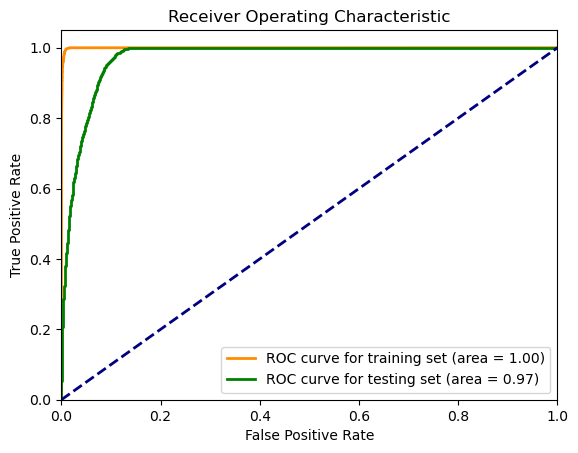

In [26]:
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='ROC curve for training set (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=lw, label='ROC curve for testing set (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()